In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 56.8 MB/s eta 0:00:00


In [ ]:
#Import necessary libraries
import ultralytics
from ultralytics import YOLO
from google.colab import drive
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cat /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/data.yaml

train: /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/train/images
val: /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/valid/images
test: /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/test/images

nc: 3
names: ['cigarette', 'nonSmoker', 'smoker']

roboflow:
  workspace: alt-f4-dom2z
  project: smoking_detection_v3_noisefree
  version: 1
  license: Public Domain
  url: https://universe.roboflow.com/alt-f4-dom2z/smoking_detection_v3_noisefree/dataset/1

In [ ]:
# Define the weighted focal loss function
def focal_loss_with_weights(pred, target, weights, gamma=2.0):
    ce_loss = torch.nn.functional.cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-ce_loss)
    weighted_loss = weights[target] * (1 - pt) ** gamma * ce_loss
    return weighted_loss.mean()

In [ ]:
# Class weights (replace with actual dataset counts)
class_counts = {'cigarette': 1899, 'nonSmoker': 2155, 'smoker': 1899}
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
scaling_factor = 1.5  # Emphasize cigarette detection
weights_tensor = torch.tensor([
    class_weights['cigarette'] * scaling_factor,
    class_weights['nonSmoker'],
    class_weights['smoker']
], dtype=torch.float32)


In [ ]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:01<00:00, 46.4MB/s]


In [ ]:
# Replace the default loss function with the custom weighted focal loss
model.loss_fn = lambda pred, target: focal_loss_with_weights(pred, target, weights_tensor)

# Freeze initial layers for fine-tuning
for idx, param in enumerate(model.model.parameters()):
    if idx < 10:  # Freeze the first 10 layers
        param.requires_grad = False

# Define the optimizer and scheduler
# lr0 = 0.001  #0.001  # Best learning rate found
# weight_decay = 0.0005  #0.0005  # Best weight decay found
# lrf = 0.1  #0.1  # Best final learning rate factor found
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr0, weight_decay=weight_decay)
###### scheduler = CosineAnnealingLR(optimizer, T_max=100)  # Scheduler for 100 epochs


In [ ]:
# Train the model with custom parameters

model.train(data='/content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/data.yaml',
            epochs=150,  # Train for one epoch at a time
            imgsz=640,
            batch=8,
            lr0=0.001,  # Best initial learning rate
            lrf=0.1,  # Best final learning rate factor
            weight_decay=0.0005,
            label_smoothing=0.1,  # Best label smoothing value
            optimizer='AdamW',
            workers=4,
            patience=15)  # Custom optimizer



WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/data.yaml, epochs=150, time=None, patience=15, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

train: Scanning /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/train/labels... 788 images, 20 backgrounds, 0 corrupt: 100%|██████████| 808/808 [09:33<00:00,  1.41it/s]


train: New cache created: /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/valid/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [01:51<00:00,  1.36it/s]

val: New cache created: /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.91G      0.586      1.093     0.9993         92        640: 100%|██████████| 101/101 [00:41<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

                   all        151        999       0.62      0.739      0.697      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      3.81G     0.5639     0.7758      0.985         91        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]

                   all        151        999      0.745      0.754       0.79      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      3.83G     0.5772     0.7427     0.9974         89        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        151        999      0.721       0.73      0.777      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      3.84G     0.5818     0.7151     0.9946        112        640: 100%|██████████| 101/101 [00:37<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


                   all        151        999      0.765      0.781      0.805      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       3.8G     0.5578      0.679     0.9815        144        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

                   all        151        999      0.744      0.808      0.797      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      3.83G     0.5449     0.6605     0.9717        109        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        151        999      0.816      0.824      0.858      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      3.75G     0.5145     0.6367       0.96        124        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        151        999      0.833      0.838      0.877      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      3.85G     0.5018     0.5959     0.9562        107        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        151        999      0.862      0.881      0.893      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.81G     0.5008     0.5681      0.945         99        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all        151        999      0.832      0.861       0.88      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.83G     0.4997     0.5668     0.9467         64        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        151        999      0.824      0.858      0.886      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       3.8G     0.4972     0.5436     0.9568         82        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

                   all        151        999       0.86       0.86      0.903      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      3.81G      0.478     0.5247     0.9334        107        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


                   all        151        999      0.879      0.847      0.904      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      3.84G     0.4859     0.5294     0.9448        129        640: 100%|██████████| 101/101 [00:37<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        151        999      0.861      0.859       0.91      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.84G     0.4722     0.5117     0.9384         76        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

                   all        151        999      0.888      0.871      0.905      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      3.74G     0.4738     0.5047     0.9379         87        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

                   all        151        999      0.868       0.87      0.899      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.84G     0.4553     0.4894     0.9249        113        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


                   all        151        999       0.86      0.871      0.903      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.85G     0.4487     0.4947     0.9259        135        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


                   all        151        999      0.848      0.855      0.891      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      3.81G     0.4662     0.4964     0.9363        101        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

                   all        151        999      0.882      0.878      0.917      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      3.84G     0.4415     0.4738     0.9219         93        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        151        999      0.907      0.904       0.94      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      3.82G     0.4404     0.4591     0.9192        101        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

                   all        151        999      0.876      0.884      0.917      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      3.82G     0.4423     0.4476     0.9168        128        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

                   all        151        999      0.844      0.878      0.906      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      3.82G     0.4417     0.4541     0.9196         92        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        151        999      0.875      0.842      0.894       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      3.74G      0.444     0.4468     0.9217        121        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        151        999      0.884      0.869      0.919      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      3.84G     0.4333     0.4439     0.9166        111        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

                   all        151        999      0.906      0.882      0.931      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      3.83G     0.4226     0.4343      0.911         87        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        151        999      0.897      0.887      0.927      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      3.81G     0.4328     0.4356     0.9197         74        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        151        999      0.886      0.894      0.924      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      3.83G     0.4198     0.4295     0.9113         87        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        151        999      0.905      0.892      0.941      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      3.81G     0.4192     0.4182     0.9161         98        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        151        999      0.929      0.893      0.938      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      3.83G     0.4102     0.4048     0.9006        131        640: 100%|██████████| 101/101 [00:37<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        151        999      0.897      0.897      0.933      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      3.83G     0.4211     0.4187     0.9105         86        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        151        999      0.883      0.892       0.93      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      3.75G     0.4051     0.4111     0.9055        104        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        151        999      0.885      0.883      0.919      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      3.84G     0.4069     0.4092     0.9057         96        640: 100%|██████████| 101/101 [00:39<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

                   all        151        999      0.896      0.906      0.937      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      3.82G     0.4037     0.3978     0.9067         68        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        151        999      0.922      0.904      0.943      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      3.83G     0.4047     0.3981     0.9014        109        640: 100%|██████████| 101/101 [00:38<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


                   all        151        999      0.905      0.913      0.935      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      3.82G      0.393     0.3819        0.9         75        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        151        999      0.919      0.908      0.942      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      3.81G     0.3948     0.3772     0.8983         63        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

                   all        151        999      0.922       0.92      0.946      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      3.82G     0.3833     0.3781     0.8958        127        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]

                   all        151        999      0.931      0.904      0.946      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       3.8G     0.4026     0.3979     0.9072         76        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

                   all        151        999      0.912      0.896      0.943      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      3.76G     0.3931     0.3867     0.9004        109        640: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        151        999      0.906      0.896      0.934      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      3.83G     0.3883     0.3825     0.8996        106        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        151        999      0.935      0.881      0.936      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      3.82G     0.3833     0.3716     0.8931        117        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        151        999      0.898      0.898       0.93      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      3.84G     0.3753     0.3607     0.8901        118        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

                   all        151        999      0.932      0.893      0.939      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      3.84G     0.3742     0.3696      0.889        128        640: 100%|██████████| 101/101 [00:39<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        151        999      0.915        0.9      0.942      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      3.84G     0.3726     0.3628     0.8899        104        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all        151        999      0.916      0.904      0.942      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      3.81G     0.3795     0.3666      0.891        109        640: 100%|██████████| 101/101 [00:39<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        151        999      0.924      0.907      0.943      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      3.82G      0.381     0.3613     0.8943         77        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]

                   all        151        999      0.936      0.902      0.943      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      3.75G     0.3782     0.3635     0.8909        116        640: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

                   all        151        999      0.911      0.912      0.943      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      3.84G     0.3703     0.3457     0.8862         75        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        151        999      0.927      0.904      0.944      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      3.83G     0.3672      0.353     0.8869         89        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        151        999      0.916      0.899      0.942      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      3.85G     0.3681     0.3568     0.8927         94        640: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]

                   all        151        999      0.925      0.919       0.95      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      3.81G     0.3638     0.3449     0.8892         82        640: 100%|██████████| 101/101 [00:39<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        151        999      0.931      0.903      0.945      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      3.83G     0.3618     0.3389     0.8795         90        640: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

                   all        151        999      0.926      0.898       0.94      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      3.82G     0.3732     0.3507     0.8934        100        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

                   all        151        999      0.921      0.909      0.944       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      3.79G     0.3687     0.3352      0.888         80        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        151        999       0.93      0.911      0.955      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      3.75G     0.3792     0.3465     0.8893        108        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        151        999      0.926      0.918      0.953      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      3.82G     0.3551     0.3345      0.879        100        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

                   all        151        999      0.946      0.906      0.955      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      3.83G     0.3584     0.3356     0.8896        106        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

                   all        151        999      0.938      0.905      0.949      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      3.81G     0.3502     0.3165     0.8823        106        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

                   all        151        999      0.925      0.907      0.948      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      3.84G     0.3566       0.33     0.8811        121        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

                   all        151        999      0.934      0.901      0.942      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      3.84G     0.3551     0.3234     0.8783        116        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        151        999      0.923      0.911      0.945      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      3.83G     0.3487     0.3174     0.8792        103        640: 100%|██████████| 101/101 [00:37<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

                   all        151        999       0.93      0.908      0.951      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      3.84G     0.3533     0.3316     0.8771        123        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        151        999      0.916       0.91      0.948      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      3.75G     0.3433     0.3212     0.8775        108        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]

                   all        151        999      0.927      0.921      0.955      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      3.81G     0.3491     0.3133     0.8836         93        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

                   all        151        999      0.939      0.917      0.952      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      3.84G     0.3424     0.3158     0.8776        135        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

                   all        151        999      0.933      0.915      0.946      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      3.81G     0.3481      0.318     0.8798        108        640: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        151        999      0.934      0.905      0.949      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      3.83G     0.3519     0.3147     0.8815        123        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        151        999      0.911      0.916      0.946      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      3.83G     0.3529      0.315      0.889         80        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

                   all        151        999      0.933      0.905      0.952      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150       3.8G     0.3385     0.3168     0.8805        117        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        151        999      0.932      0.913      0.952      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      3.81G     0.3358     0.3116     0.8744        105        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        151        999      0.936       0.91      0.951      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      3.73G     0.3318     0.3052     0.8703        105        640: 100%|██████████| 101/101 [00:39<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        151        999       0.94      0.925      0.959      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      3.82G     0.3396     0.3052      0.873         75        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        151        999      0.933      0.926      0.959      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      3.83G     0.3345     0.2957     0.8691         94        640: 100%|██████████| 101/101 [00:37<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        151        999      0.939      0.908      0.956      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      3.83G     0.3333     0.2898     0.8746         90        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

                   all        151        999      0.927       0.91       0.95      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      3.79G     0.3357     0.3059     0.8741         90        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        151        999       0.95      0.913      0.954      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      3.83G     0.3367     0.2992      0.874         75        640: 100%|██████████| 101/101 [00:38<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        151        999      0.946      0.917      0.957        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      3.82G     0.3344     0.2923     0.8729         90        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        151        999      0.937      0.917      0.954      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      3.82G     0.3231      0.291     0.8664         99        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


                   all        151        999      0.932       0.92      0.957      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      3.74G     0.3184     0.2879     0.8694        104        640: 100%|██████████| 101/101 [00:38<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        151        999      0.941      0.916      0.962      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      3.84G     0.3199     0.2893      0.865        102        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

                   all        151        999      0.939      0.929       0.96      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      3.81G     0.3257       0.29     0.8722         91        640: 100%|██████████| 101/101 [00:38<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        151        999      0.932      0.922      0.959      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      3.82G     0.3268     0.2846     0.8693        119        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

                   all        151        999      0.944      0.927      0.962      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      3.81G     0.3229     0.2864     0.8716        122        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

                   all        151        999      0.947      0.928      0.964      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      3.81G     0.3165     0.2805     0.8655        102        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

                   all        151        999      0.939      0.925      0.963       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      3.83G     0.3183     0.2853     0.8676         86        640: 100%|██████████| 101/101 [00:37<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        151        999       0.93      0.925      0.962      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      3.81G     0.3102     0.2803     0.8575         93        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        151        999      0.932      0.927       0.96      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      3.75G     0.3138     0.2837     0.8613        104        640: 100%|██████████| 101/101 [00:37<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        151        999      0.951      0.916      0.963      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      3.82G     0.3236      0.292     0.8728        129        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

                   all        151        999      0.943      0.919      0.954      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      3.85G     0.3176     0.2742     0.8661         98        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        151        999      0.938      0.932      0.957      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      3.81G     0.3082     0.2689      0.863         79        640: 100%|██████████| 101/101 [00:38<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        151        999      0.933      0.934      0.962      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      3.81G     0.3095     0.2642      0.863         83        640: 100%|██████████| 101/101 [00:37<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        151        999      0.931      0.922      0.959      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      3.84G     0.3063     0.2734     0.8587        111        640: 100%|██████████| 101/101 [00:38<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        151        999      0.936      0.925      0.958      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      3.84G     0.3153     0.2877     0.8609         83        640: 100%|██████████| 101/101 [00:37<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        151        999      0.946      0.925      0.961      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      3.83G     0.3067     0.2686     0.8612         96        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

                   all        151        999       0.92      0.923       0.95      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      3.74G      0.311     0.2755     0.8652         66        640: 100%|██████████| 101/101 [00:37<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        151        999      0.926      0.922      0.959      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      3.84G     0.3137     0.2883     0.8671        125        640: 100%|██████████| 101/101 [00:37<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        151        999      0.955      0.901      0.955      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      3.83G     0.3137     0.2832     0.8704        105        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        151        999      0.952      0.904      0.959      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      3.84G     0.3079     0.2649     0.8664        105        640: 100%|██████████| 101/101 [00:37<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        151        999      0.928      0.929      0.959      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      3.82G     0.2992      0.259     0.8575        105        640: 100%|██████████| 101/101 [00:37<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]

                   all        151        999      0.942      0.921      0.959        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      3.81G     0.3007     0.2628     0.8628         72        640: 100%|██████████| 101/101 [00:38<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

                   all        151        999      0.919      0.928      0.959      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      3.84G     0.3063     0.2629     0.8621        123        640: 100%|██████████| 101/101 [00:38<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        151        999       0.93       0.93      0.956      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      3.79G     0.3052     0.2642     0.8642         74        640: 100%|██████████| 101/101 [00:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]

                   all        151        999      0.948      0.922      0.957      0.803


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 87, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

102 epochs completed in 1.261 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


                   all        151        999       0.95      0.916      0.963      0.814
             cigarette        142        330      0.929      0.809      0.919      0.509
             nonSmoker        133        339      0.966      0.965      0.984      0.956
                smoker        142        330      0.957      0.976      0.985      0.976
Speed: 0.2ms preprocess, 6.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5ae6be53f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
# Evaluate model with custom IoU threshold
model.val(iou=0.4)  # Set IoU threshold to 0.4 to improve small object detection

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/MyDrive/FYDP/Smoking_Detection_V3_noiseFree.v1-sd_dataset_clean.yolov8/valid/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


                   all        151        999      0.942      0.924      0.963      0.816
             cigarette        142        330       0.92       0.83      0.927      0.522
             nonSmoker        133        339      0.953      0.959      0.978       0.95
                smoker        142        330      0.953      0.982      0.985      0.976
Speed: 0.3ms preprocess, 17.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5ae649faf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:


# Load the training results
results_path = '/content/runs/detect/train2/results.csv'  # Adjust path if using a different name
results = pd.read_csv(results_path)


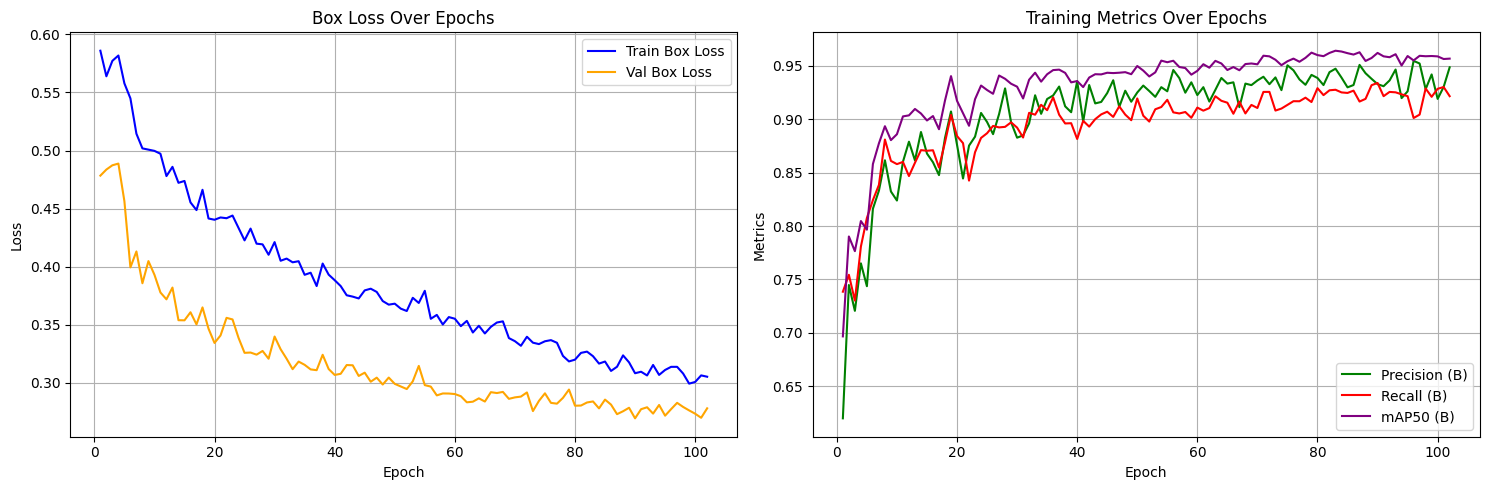

In [ ]:
# Plot training/validation loss and metrics
plt.figure(figsize=(15, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', color='orange')
plt.title('Box Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Training Metrics
plt.subplot(1, 2, 2)
plt.plot(results['epoch'], results['metrics/precision(B)'], label='Precision (B)', color='green')
plt.plot(results['epoch'], results['metrics/recall(B)'], label='Recall (B)', color='red')
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50 (B)', color='purple')
plt.title('Training Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


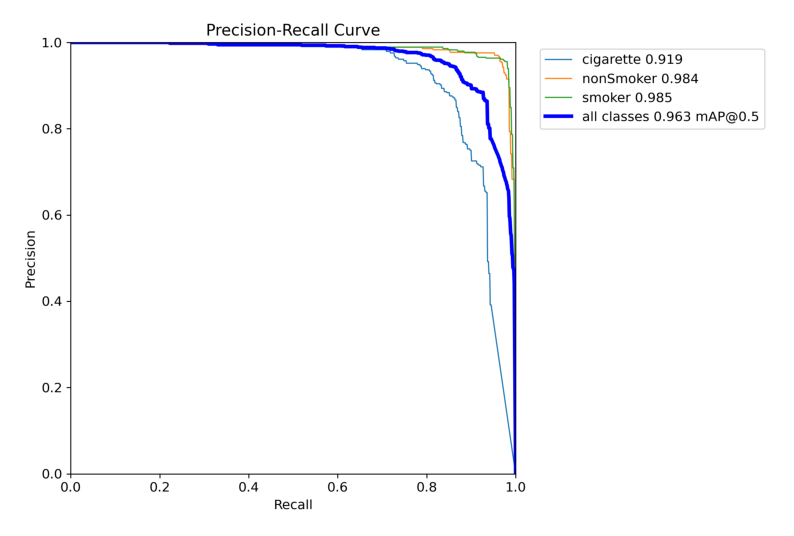

In [ ]:
from PIL import Image

# Load and display the saved PR curve image
pr_curve_image = Image.open('/content/runs/detect/train2/PR_curve.png')
plt.figure(figsize=(10, 8))
plt.imshow(pr_curve_image)
plt.axis('off')  # Hide axes for image
plt.show()


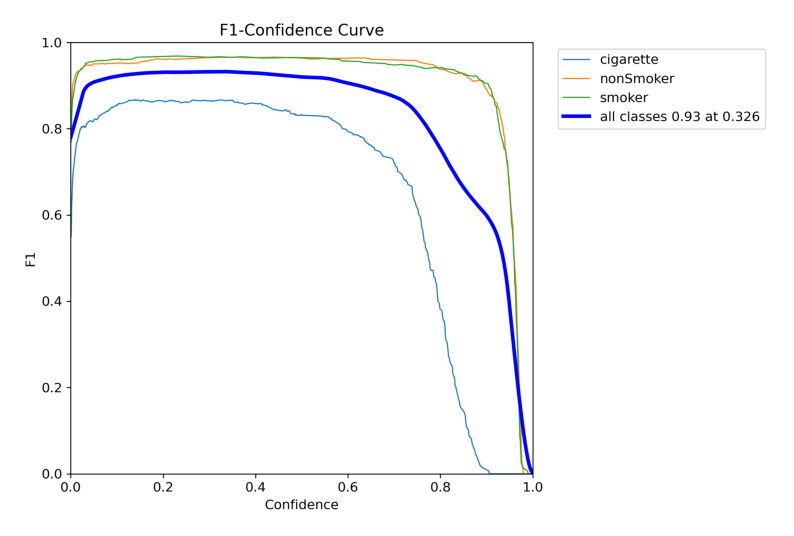

In [ ]:
# Load and display the saved F1 curve image
f1_curve_image = Image.open('/content/runs/detect/train2/F1_curve.png')  # Adjust path if needed
plt.figure(figsize=(10, 8))
plt.imshow(f1_curve_image)
plt.axis('off')  # Hide axes for image
plt.show()


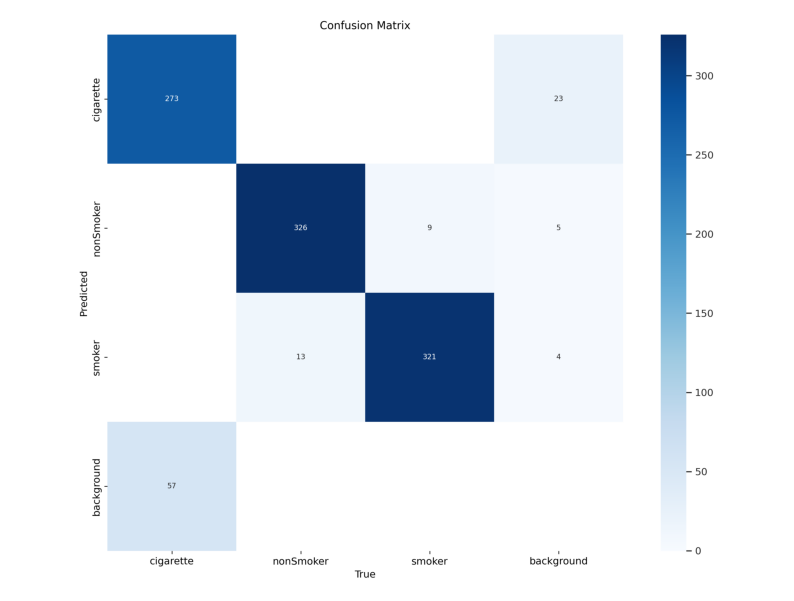

In [ ]:
# Load and display the saved confusion matrix image
conf_matrix_image = Image.open('/content/runs/detect/train2/confusion_matrix.png')  # Adjust path if needed
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_image)
plt.axis('off')  # Hide axes for image
plt.show()


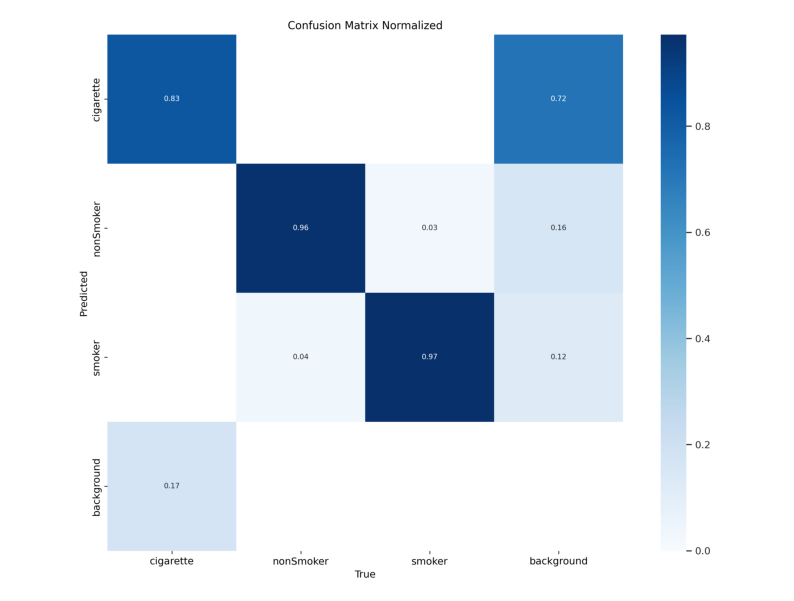

In [ ]:
# Load and display the saved confusion matrix image
conf_matrix_image = Image.open('/content/runs/detect/train2/confusion_matrix_normalized.png')  # Adjust path if needed
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_image)
plt.axis('off')  # Hide axes for image
plt.show()


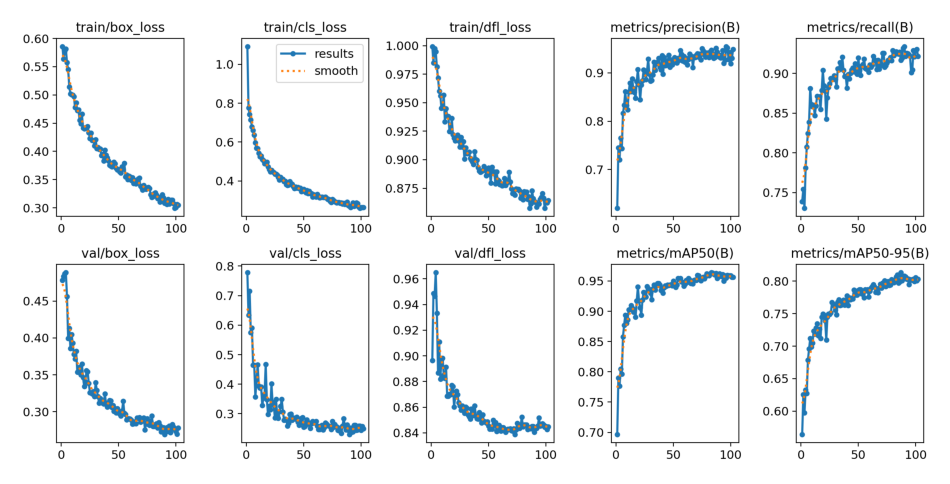

In [ ]:
# Load and display the saved confusion matrix image
conf_matrix_image = Image.open('/content/runs/detect/train2/results.png')  # Adjust path if needed
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix_image)
plt.axis('off')  # Hide axes for image
plt.show()


In [ ]:
model.save('trained_model_SD_large_v2_noiseFree.pt')  # Save the model as best_model.pt


In [ ]:
import shutil

# Path to your best_model.pt file
source = '/content/trained_model_SD_large_v2_noiseFree.pt'

# Destination path in your Google Drive
destination = '/content/drive/MyDrive/FYDP/SD_training_large_V2_noiseFree/trained_model_SD_large_v2_noiseFree.pt'

# Copy the file
shutil.copy(source, destination)


'/content/drive/MyDrive/FYDP/SD_training_large_V2_noiseFree/trained_model_SD_large_v2_noiseFree.pt'

In [ ]:

# Define the source directory (replace train with train2 if needed)
source_dir = '/content/runs/detect/train2'

# Destination path in Google Drive
destination_dir = '/content/drive/MyDrive/FYDP/SD_training_large_V2_noiseFree/train_results'  # You can rename 'train_results' as desired

# Copy the entire directory
shutil.copytree(source_dir, destination_dir)


'/content/drive/MyDrive/FYDP/SD_training_large_V2_noiseFree/train_results'

In [ ]:
import shutil

# Define the source directory (replace train with train2 if needed)
source_dir = '/content/runs/detect/train22'

# Destination path in Google Drive
destination_dir = '/content/drive/MyDrive/FYDP/SD_training_large_V2_noiseFree/train2_results'  # You can rename 'train_results' as desired

# Copy the entire directory
shutil.copytree(source_dir, destination_dir)


'/content/drive/MyDrive/FYDP/SD_training_large_V2_noiseFree/train2_results'